🧠 AI/Ml & Predictive Analyst


📦 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [8]:
# load data set

customers = pd.read_csv("customers.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")


📊 2. Exploratory Data Analysis (EDA)

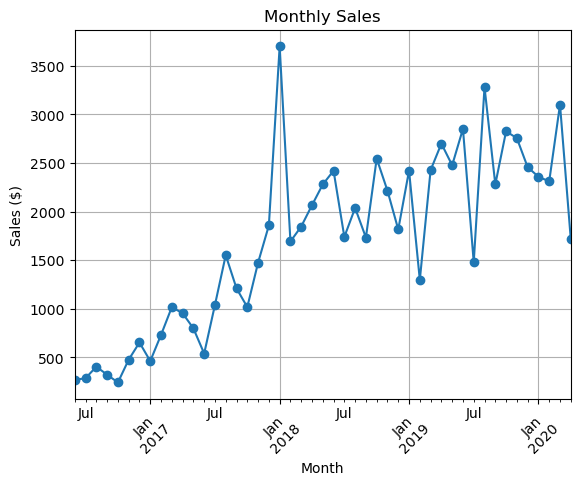

In [10]:
# Order trends
orders['Created At'] = pd.to_datetime(orders['Created At'])
orders['Month'] = orders['Created At'].dt.to_period('M')

monthly_sales = orders.groupby('Month')['Total'].sum()
monthly_sales.plot(kind='line', title='Monthly Sales', marker='o')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


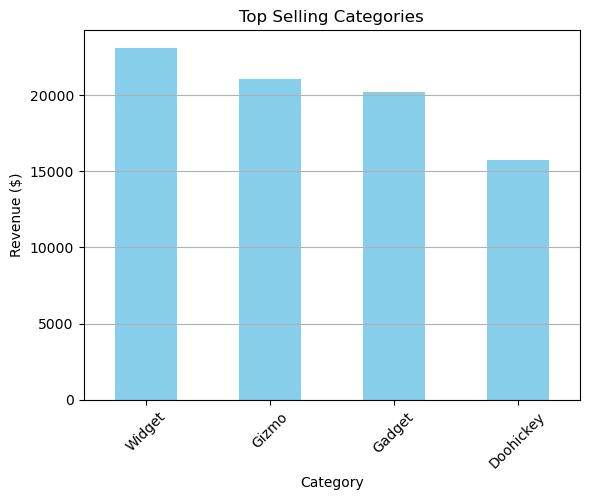

In [12]:
# Top selling product categories
merged = orders.merge(products, left_on='Product ID', right_on='ID')
top_categories = merged.groupby('Category')['Total'].sum().sort_values(ascending=False)

top_categories.plot(kind='bar', title='Top Selling Categories', color='skyblue')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



🧬 3. Customer Segmentation (KMeans Clustering)

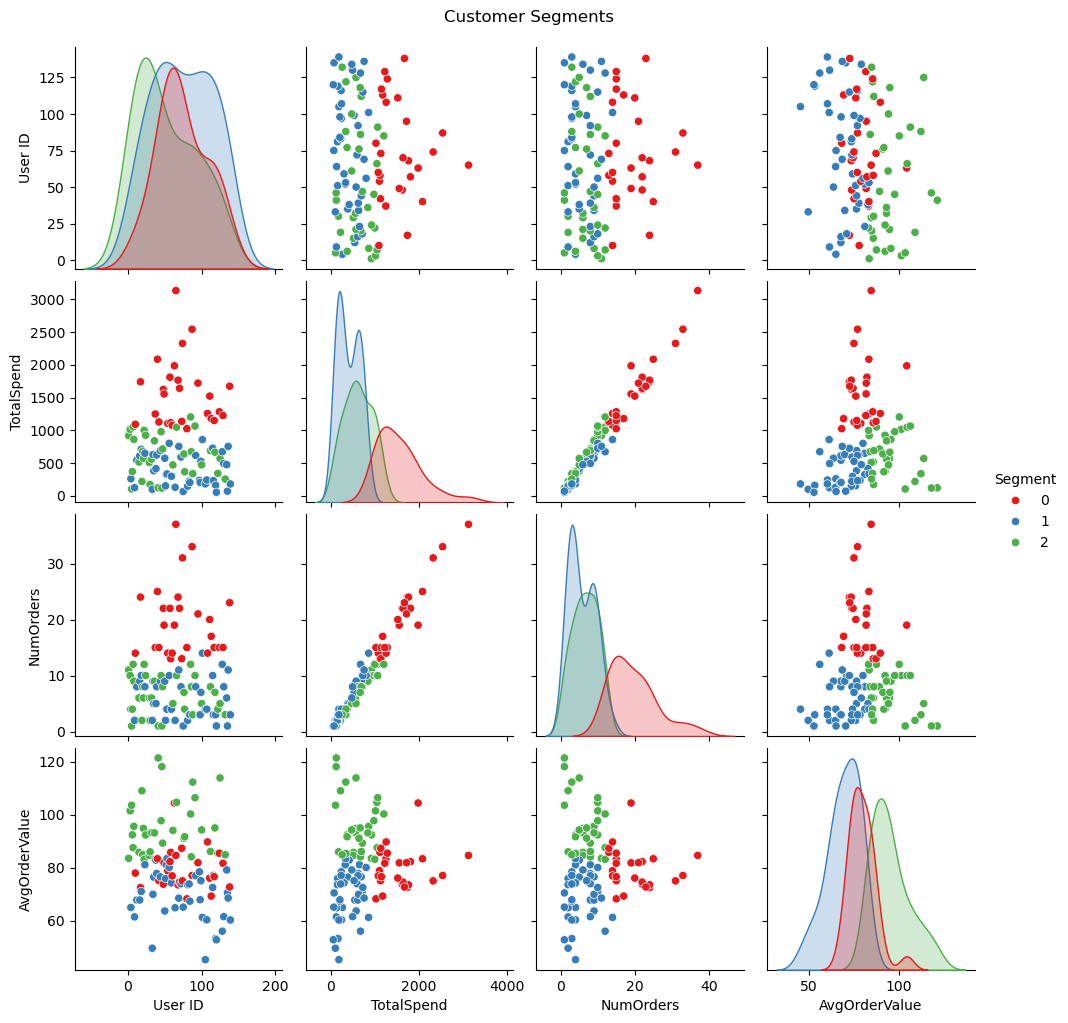

In [14]:
# Aggregate customer metrics
customer_orders = orders.groupby('User ID').agg({'Total': 'sum', 'ID': 'count'})
customer_orders.columns = ['TotalSpend', 'NumOrders']
customer_orders['AvgOrderValue'] = customer_orders['TotalSpend'] / customer_orders['NumOrders']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_orders)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_orders['Segment'] = kmeans.fit_predict(X_scaled)

# Plot segments
sns.pairplot(customer_orders.reset_index(), hue='Segment', palette='Set1')
plt.suptitle("Customer Segments", y=1.02)
plt.show()


🔮 4. Churn Prediction (Classification)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.75      0.86         4

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21



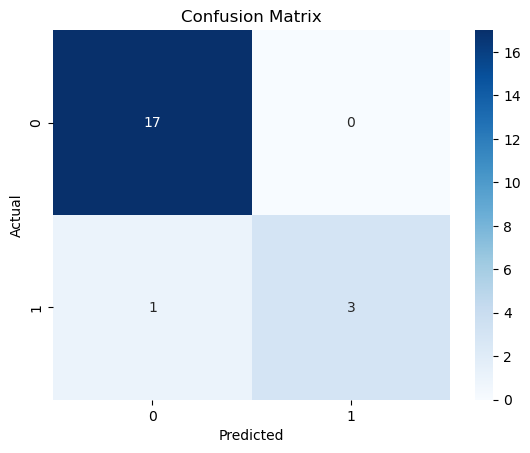

In [16]:
# Define churn: no order in the past 365 days
orders['Created At'] = pd.to_datetime(orders['Created At'])
latest_date = orders['Created At'].max()
last_orders = orders.groupby('User ID')['Created At'].max()
churn_data = pd.DataFrame({
    'LastOrderDate': last_orders,
    'Churned': last_orders < (latest_date - pd.Timedelta(days=365))
})

# Merge features
churn_data = churn_data.merge(customer_orders, left_index=True, right_index=True)

# ML model
X = churn_data[['TotalSpend', 'NumOrders', 'AvgOrderValue']]
y = churn_data['Churned'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
